# Task 1.

Moby Dick is an extremely long novel, and the size of the plain-text file containing the unabridged version is approximately 1.2 MB. (see https://gutenberg.org/ebooks/2701). However, language is relatively easy to compress, as it is very redundant.

- Encode the novel with Huffman and Shannon-Fano compression, using individual characters as symbols and estimating their probability by their relative frequency You can use any programming language to implement both the codes and the probability estimation.


In [58]:
# Import the text in the Moby dick.txt file and count the number of each character in the text.

from collections import Counter
import matplotlib.pyplot as plt
import heapq
from graphviz import Digraph
import os
import re
import math
import random

## Huffman coding algorithm

The Huffman coding algorithm is implemented by building the Huffman tree in reverse. This means computing the symbol frequency and mapping the most infrequent symbols first. The frequency of these symbols is then merged into an internal node, this process is repeated until the root of the tree is reached.


In [ ]:
class huffman_node:
    """
    Container class for each node in the huffman tree

    Attributes:
        symbol: The character or symbol which is encoded in this node
        frequency: The frequency of the symbol
        left: The left child node
        right: The right child node
    """

    def __init__(self, symbol=None, frequency=None):
        self.symbol: str = symbol
        self.frequency: int = frequency
        self.left: huffman_node = None
        self.right: huffman_node = None

    def __lt__(self, other):
        #Override the less than operator, so comparison between node objects happens based on frequency.
        return self.frequency < other.frequency


def calc_frequencies(file: str, char_based: bool):
    with open(file, encoding="utf8") as f:
        text = f.read()

    if char_based:
        # Count the character frequencies
        char_freq = Counter(text)
        # Sort the character-frequency pairs in ascending order
        sorted_freq = sorted(char_freq.items(), key=lambda item: item[1])
        characters, frequencies = zip(*sorted_freq)
        characters = list(characters)
        frequencies = list(frequencies)

        probabilities = [freq / sum(frequencies) for freq in frequencies]
        return characters, frequencies, probabilities
    else:
        # Regex pattern: "\w+" one or more words, "[^\w\s]" any character that is not a word or whitespace, "\s" any whitespace character
        pattern = r"\w+|[^\w\s]|\s"
        words = re.findall(pattern, text)
        word_freq = Counter(words)
        # Sort word-frequency pair by frequency
        sorted_freq = sorted(word_freq.items(), key=lambda item: item[1])
        words, frequencies = zip(*sorted_freq)
        words = list(words)
        frequencies = list(frequencies)

        probabilities = [freq / sum(frequencies) for freq in frequencies]
        return words, frequencies, probabilities


def build_huffman_tree(chars: list, freq: list) -> huffman_node:
    """
    Builds the Huffman tree in reverse, popping least frequent symbols and merging into parent nodes.
    Returns the root node object, from which the tree can be navigated using .left and .right
    """
    # Create a queue of nodes
    priority_queue = [huffman_node(char, f) for char, f in zip(chars, freq)]
    heapq.heapify(priority_queue) # Make a sorted heap queue (heap is more efficient than a list due to time complexity of operations)

    # Recursively merge the two least frequent nodes into a parent node, and push it back into the queue
    while len(priority_queue) > 1:
        left_child = heapq.heappop(priority_queue)
        right_child = heapq.heappop(priority_queue)
        merged_node = huffman_node(
            frequency=left_child.frequency + right_child.frequency
        )
        merged_node.left = left_child
        merged_node.right = right_child
        heapq.heappush(priority_queue, merged_node)
    root = priority_queue[0]
    return root


def visualize_huffman_tree(node: huffman_node) -> Digraph:
    """
    Visualize the huffman tree using graphviz
    """

    def add_edges(graph, node, parent=None, edge_label=""):
        if node is not None:
            node_label = (
                f"{node.symbol}:{node.frequency}"
                if node.symbol
                else f"{node.frequency}"
            )
            graph.node(str(id(node)), node_label)
            if parent:
                graph.edge(str(id(parent)), str(id(node)), edge_label)
            add_edges(graph, node.left, node, "0")
            add_edges(graph, node.right, node, "1")

    dot = Digraph()
    add_edges(dot, node)
    return dot


def generate_huffman_codes(
    node: huffman_node, code="", huffman_codes: dict = {}
) -> dict[str, str]:
    """
    Navigate through the Huffman tree assigning binary codes to each symbol
    """
    if node is not None:
        if node.symbol is not None:
            huffman_codes[node.symbol] = code
        generate_huffman_codes(node.left, code + "0", huffman_codes)
        generate_huffman_codes(node.right, code + "1", huffman_codes)
    return huffman_codes

def calc_size(symbols: list[str], frequencies: list[int], codes: dict[str, str]):
    return sum([frequencies[i] * len(codes[symbols[i]]) for i in range(len(symbols))])

### Huffman coding using characters as symbols


Original file size in bits: 1227647
Compressed file size in bits: 671252.625
Compression: 45.322016426546064%


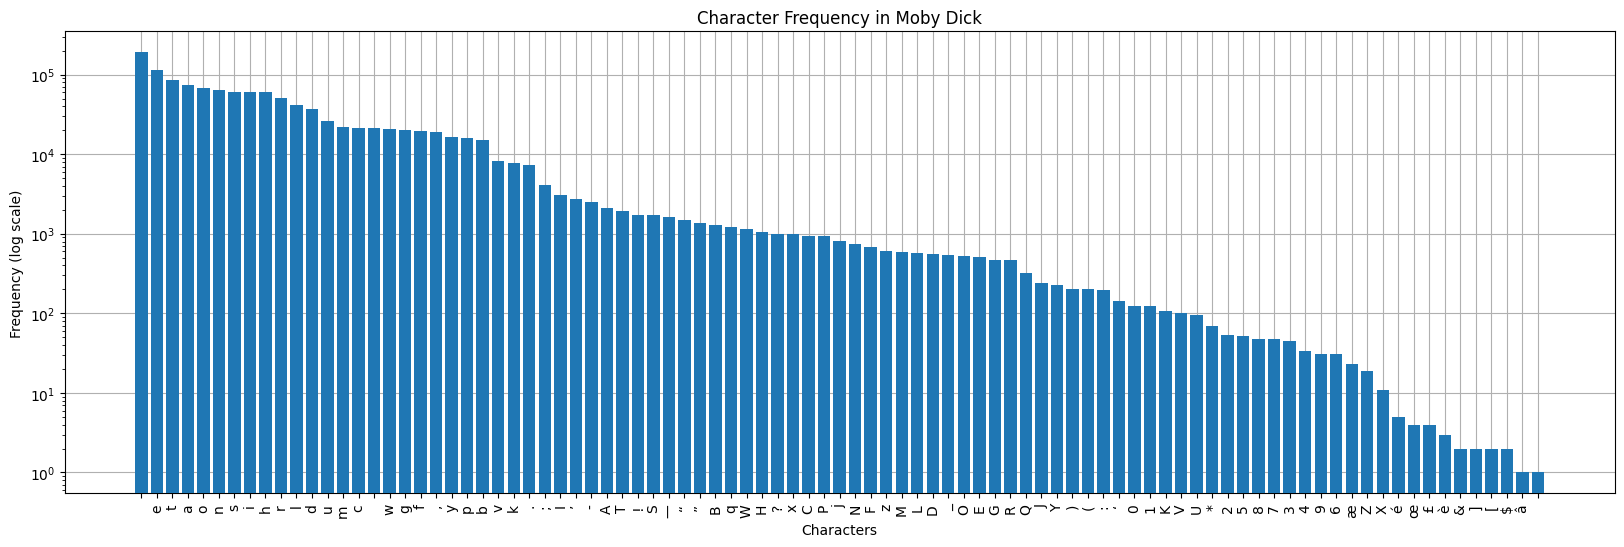

In [60]:
file = "moby_dick.txt"
with open(file, encoding="utf8") as f:
    text = f.read()

symbols, frequencies, probabilities = calc_frequencies(file, True)

# Plot the char-frequency pairs as a log histogram
plt.figure(figsize=(20, 6))
plt.bar(symbols[::-1], frequencies[::-1], log=True, zorder=3)
plt.grid(True, zorder=0)
plt.xlabel("Characters")
plt.ylabel("Frequency (log scale)")
plt.title("Character Frequency in Moby Dick")
plt.xticks(rotation=90)
# plt.show()

# Construct the Huffman tree and generate the Huffman codes for each character
root_node = build_huffman_tree(symbols, frequencies)
huffman_codes = generate_huffman_codes(root_node)

dot = visualize_huffman_tree(root_node)
dot.render("huffman_tree_chars", format="png", cleanup=True)

original_size = os.path.getsize("moby_dick.txt")
compressed_size_char_huffman = calc_size(symbols, frequencies, huffman_codes) / 8
# compressed_size_char_huffman = (sum(frequencies[i] * len(huffman_codes[symbols[i]]) for i in range(len(symbols))) / 8)


print(
    f"Original file size in bits: {original_size}\n\
Compressed file size in bits: {compressed_size_char_huffman}\n\
Compression: {(1-compressed_size_char_huffman/original_size)*100}%"
)

### Huffman coding using words as symbols


Original file size in bytes: 1227647
Compressed file size in bytes: 382313.125
Compression: 68.858057324296%


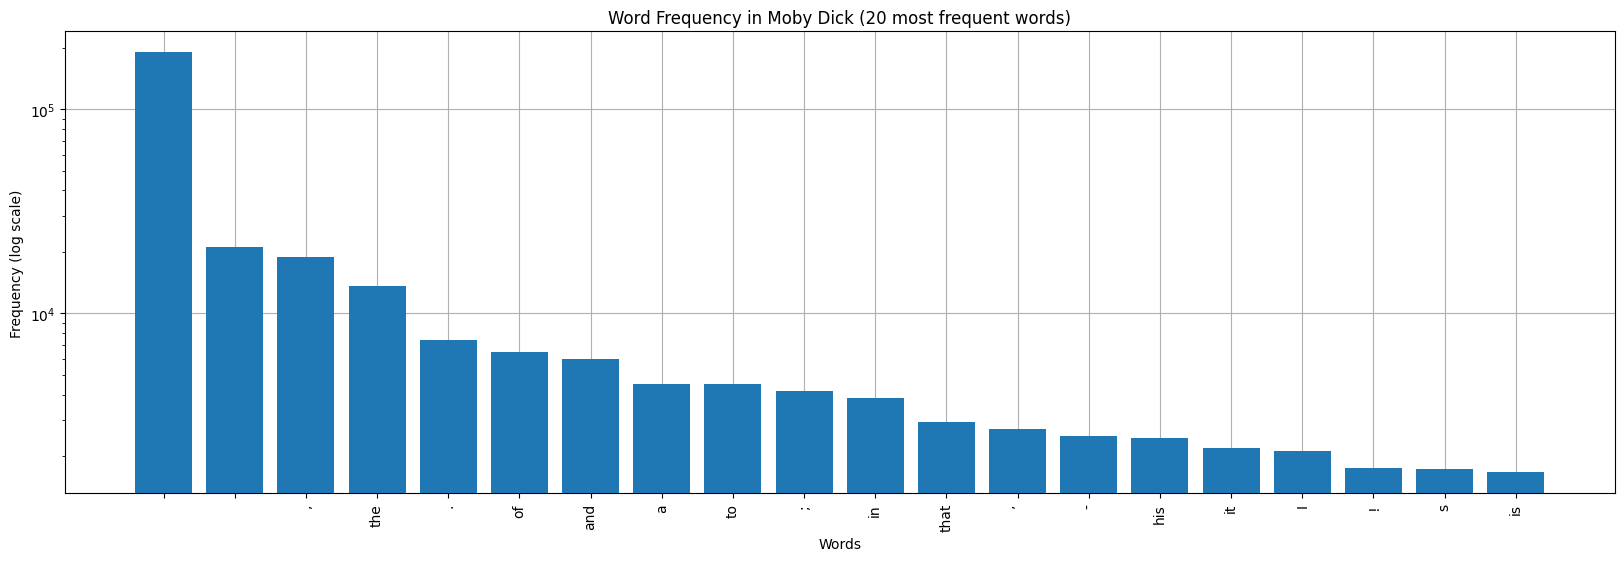

In [61]:
file = "moby_dick.txt"
symbols, frequencies, probabilities = calc_frequencies(file, char_based=False)

# Build the Huffman tree and generate the Huffman codes
root_node = build_huffman_tree(symbols, frequencies)
huffman_codes = generate_huffman_codes(root_node)

compressed_size_word_huffman = calc_size(symbols, frequencies, huffman_codes) / 8 

print(
    f"Original file size in bytes: {original_size}\n\
Compressed file size in bytes: {compressed_size_word_huffman}\n\
Compression: {(1-compressed_size_word_huffman/original_size)*100}%")

# Plot the word-frequency pairs as a log histogram
plt.figure(figsize=(20, 6))
plt.bar(symbols[-1:-21:-1], frequencies[-1:-21:-1], log=True, zorder=3)
plt.xlabel("Words")
plt.ylabel("Frequency (log scale)")
plt.grid(True, zorder=0)
plt.title("Word Frequency in Moby Dick (20 most frequent words)")
plt.xticks(rotation=90)
plt.show()

### Conclusions on Huffman Coding


Intuitively using a word-based encoding will lead to a larger Huffman tree (too large to show in this case), since there are more unique words in the text than there are unique characters (bounded by letters in the alphabet plus a limited amount of special characters). This means word-based encoding will have long Huffman codes for infrequent words.

However, due to properties of natural language patterns, words like "the", "and", "is" will appear very frequently, and the benefit of encoding these as words rather than individual characters adds up and achieves a better compression rate. This can be explained by the relative probability being higher when using word-based encoding.

The results of using the Huffman Coding algorithm for word- or character-based encoding is showcased below:

- Compression achieved using char-based coding: $45.322\%$
- Compression achieved using word-based coding: $68.858\%$

A comparison in file size, and an example of the constructed Shannon-Fano tree for char-based encoding is showcased below (word-based encoding tree is too large to show). 

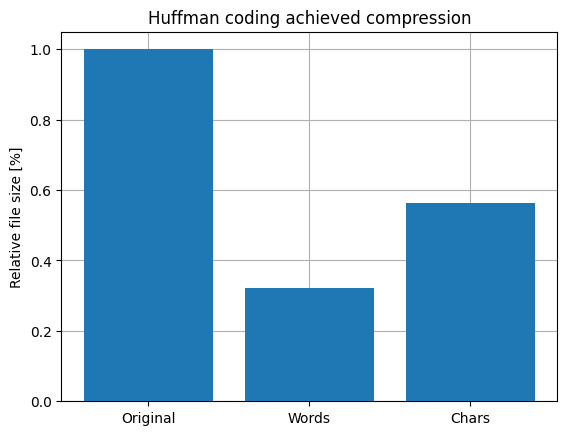

In [69]:
# Compare compression methods words/characters
x_vals = ["Original", "Words", "Chars"]
y_vals = [
    original_size / original_size,
    compressed_size_word_huffman / original_size,
    compressed_size_char_huffman / original_size,
]

plt.bar(x_vals, y_vals,zorder=3)
plt.title("Huffman coding achieved compression")
plt.grid(True, zorder=0)
plt.ylabel("Relative file size [%]")
plt.show()

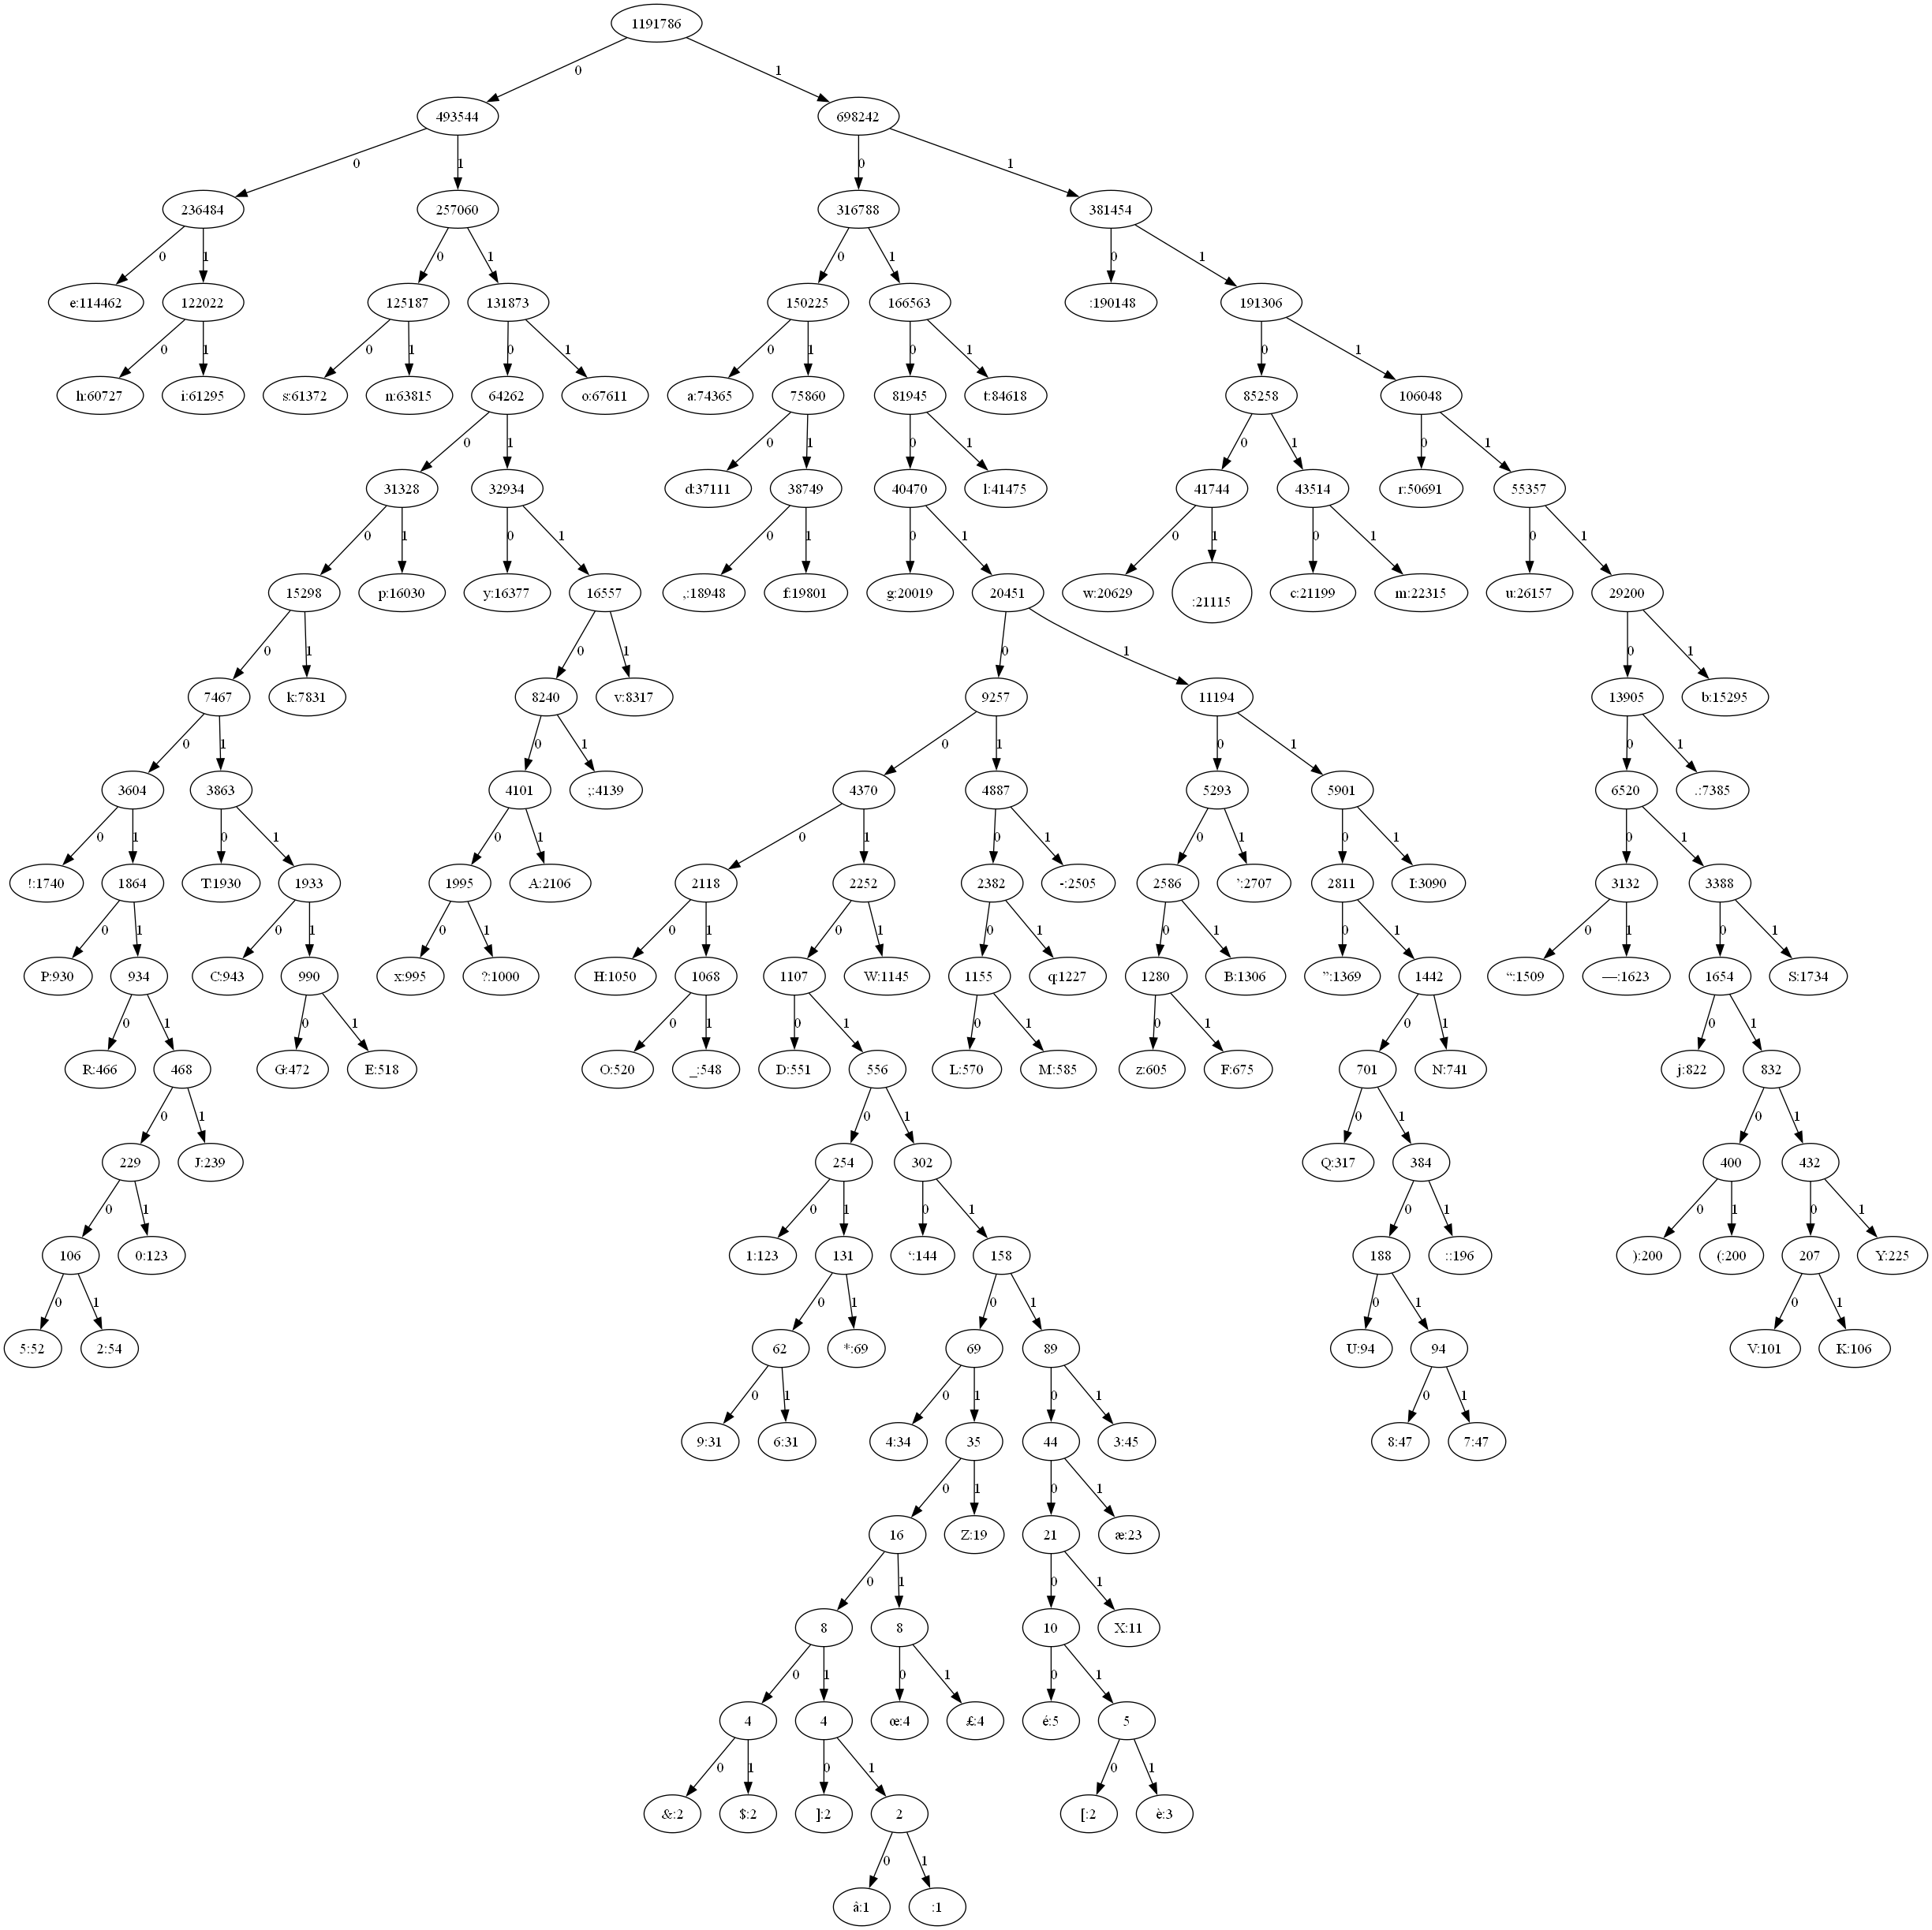

## Shannon-Fano Compression Algorithm

Below is an implementation of the Shannon-Fano algorithm, similarly to the Huffman algorithm we define a container class for the node, which contains information about the encoded symbol, frequency of that symbol as well as left and right children of the node. We use these nodes to construct the Shannon-Fano tree, in which the probability or frequency shall be split evenly in a left and right group recursively.

We do this by repeatedly adding nodes to the left group and keeping track of the cumulative frequency and how well it matches with the right group. Once the optimal split index is found, the groups are split and the process is repeated for the subgroups.


In [63]:
class Shannon_Fano_node:
    def __init__(self, symbol=None, frequency=None):
        self.symbol: str = symbol
        self.frequency: int = frequency
        self.left: Shannon_Fano_node = None
        self.right: Shannon_Fano_node = None


def calc_frequencies(
    file: str, char_based: bool
) -> tuple[list[str], list[int], list[float]]:

    with open(file, encoding="utf8") as f:
        text = f.read()

    if char_based:
        # Count the character frequencies
        char_freq = Counter(text)
        # Sort the character-frequency pairs in ascending order
        sorted_freq = sorted(char_freq.items(), key=lambda item: item[1])
        characters, frequencies = zip(*sorted_freq)
        characters: list[str] = list(characters)
        frequencies: list[str] = list(frequencies)

        probabilities: list[float] = [freq / sum(frequencies) for freq in frequencies]
        return characters, frequencies, probabilities
    else:
        # Regex pattern: "\w+" one or more words, "[^\w\s]" any character that is not a word or whitespace, "\s" any whitespace character
        pattern = r"\w+|[^\w\s]|\s"
        words = re.findall(pattern, text)
        word_freq = Counter(words)
        # Sort word-frequency pair by frequency
        sorted_freq = sorted(word_freq.items(), key=lambda item: item[1])
        words, frequencies = zip(*sorted_freq)
        words: list[str] = list(words)
        frequencies: list[str] = list(frequencies)

        probabilities: list[float] = [freq / sum(frequencies) for freq in frequencies]
        return words, frequencies, probabilities


def make_nodes(characters: list, frequencies: list) -> list[Shannon_Fano_node]:
    #loop through the characters and frequencies and create a Shannon_Fano_node for each character
    nodes = [Shannon_Fano_node(char, freq) for char, freq in zip(characters, frequencies)]
    return sorted(nodes, key=lambda node: node.frequency, reverse=True)


def build_shannon_fano_tree(nodes):
	"""Builds the shannon_fano_tree using the shannon_fano_node class. Finds the optimal split index to ensure similar frequency distribution in left and right nodes.

	Args:
		nodes (list[Shannon_Fano_node]): Container class for each node in the shannon fano tree 

	Returns:
		Shannon_Fano_node: The root node of the shannon fano tree
	""" 
    
	if len(nodes) == 1:
		return nodes[0]

	nodes.sort(key=lambda node: node.frequency, reverse=True)
	total_freq = sum(node.frequency for node in nodes)
	cumulative_freq = 0
	split_index = 0

	# Find the optimal split index to ensure similar frequency distribution in left and right nodes
	for i, node in enumerate(nodes):
		cumulative_freq += node.frequency
		if cumulative_freq >= total_freq / 2:
			split_index = i
			break

	# Assign the left and right nodes
	left_nodes = nodes[: split_index + 1]
	right_nodes = nodes[split_index + 1 :]

	# Recursively build the tree
	parent = Shannon_Fano_node()
	parent.left = build_shannon_fano_tree(left_nodes)
	parent.right = build_shannon_fano_tree(right_nodes)
	parent.frequency = total_freq

	return parent


def generate_shannon_fano_codes(node, code="", shannon_fano_codes={}):
    if node is not None:
        if node.symbol is not None:
            shannon_fano_codes[node.symbol] = code
        generate_shannon_fano_codes(node.left, code + "0", shannon_fano_codes)
        generate_shannon_fano_codes(node.right, code + "1", shannon_fano_codes)
    return shannon_fano_codes


def visualize_shannon_fano_tree(node):
    def add_edges(graph, node, parent=None, edge_label=""):
        if node is not None:
            node_label = (
                f"{node.symbol}:{node.frequency}"
                if node.symbol
                else f"{node.frequency}"
            )
            graph.node(str(id(node)), node_label)
            if parent:
                graph.edge(str(id(parent)), str(id(node)), edge_label)
            add_edges(graph, node.left, node, "0")
            add_edges(graph, node.right, node, "1")

    dot = Digraph()
    add_edges(dot, node)
    return dot


def calc_size(symbols: list[str], frequencies: list[int], codes: dict[str, str]):
    return sum([frequencies[i] * len(codes[symbols[i]]) for i in range(len(symbols))])


### Shannon-Fano compression using characters as symbols


In [64]:
#Find character-frequency pairs
file = "moby_dick.txt"
symbols, frequencies, probabilities = calc_frequencies(file, char_based=True)

#Construct the shannon-fano tree and assign shannon-fano codes
nodes = make_nodes(symbols, frequencies)
root_node = build_shannon_fano_tree(nodes)
shannon_fano_codes = generate_shannon_fano_codes(root_node)

# Visualize the Shannon-Fano tree
dot = visualize_shannon_fano_tree(root_node)
dot.render("shannon_fano_tree_chars", format="png", cleanup=True)

#Size comparison
original_size = os.path.getsize(file)
compressed_size_char_shannon = calc_size(symbols,frequencies,shannon_fano_codes) / 8 

print(f"Original file size in bytes: {original_size}\n\
Compressed file size in bytes: {compressed_size_char_shannon}\n\
Compression: {(1-compressed_size_char_shannon/original_size)*100}%")

Original file size in bytes: 1227647
Compressed file size in bytes: 693932.625
Compression: 43.47457982628556%


### Shannon-Fano coding using words as symbols


In [65]:
#Find word-frequency pairs
file = "moby_dick.txt"
symbols, frequencies, probabilities = calc_frequencies(file, char_based=False)

#Make shannon-fano nodes out of the word-frequency pairs
nodes = make_nodes(symbols, frequencies)

#Construct the shannon-fano tree and assign codes
root_node = build_shannon_fano_tree(nodes)
shannon_fano_codes = generate_shannon_fano_codes(root_node)

compressed_size_word_shannon = calc_size(symbols,frequencies,shannon_fano_codes) / 8 

print(
f"Original file size in bytes: {original_size}\n\
Compressed file size in bytes: {compressed_size_word_shannon}\n\
Compression: {(1-compressed_size_word_shannon/original_size)*100}%")

Original file size in bytes: 1227647
Compressed file size in bytes: 391128.375
Compression: 68.13999667656908%


### Conclusions on Shannon-Fano coding


Similarly to Huffman coding, the character-based compression performs worse than the word-based compression. Likely due to natural language structure, where certain words are repeated many times and being able to encode these with a short codeword is very benefitial. Besides this Shannon-Fano coding performs slightly worse than Huffman in terms of file size after compression, this is as expected from the theory where Huffman is slightly closer to the theoretical maximum compression based on information-entropy.

The results of using the Shannon-Fano Coding algorithm for word- or character-based encoding is showcased below:

- Compression achieved using char-based coding: $43.475\%$
- Compression achieved using word-based coding: $68.140\%$

A comparison in file size, and an example of the constructed Shannon-Fano tree for char-based encoding is showcased below (word-based encoding tree is too large to show). 

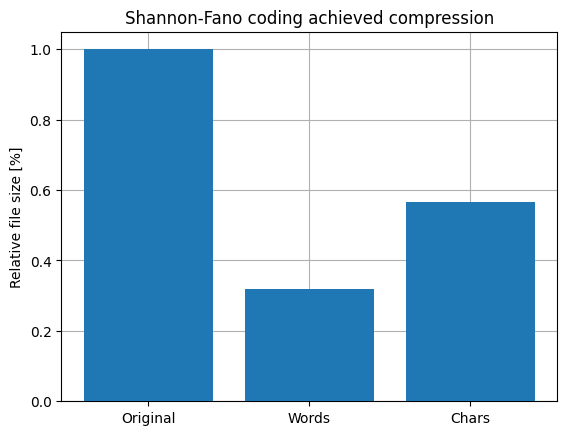

In [66]:
# Compare compression methods words/characters
x_vals = ["Original", "Words", "Chars"]
y_vals = [
    original_size / original_size,
    compressed_size_word_shannon / original_size,
    compressed_size_char_shannon / original_size,
]

plt.bar(x_vals, y_vals,zorder=3)
plt.grid(True, zorder=0)
plt.title("Shannon-Fano coding achieved compression")
plt.ylabel("Relative file size [%]")
plt.show()

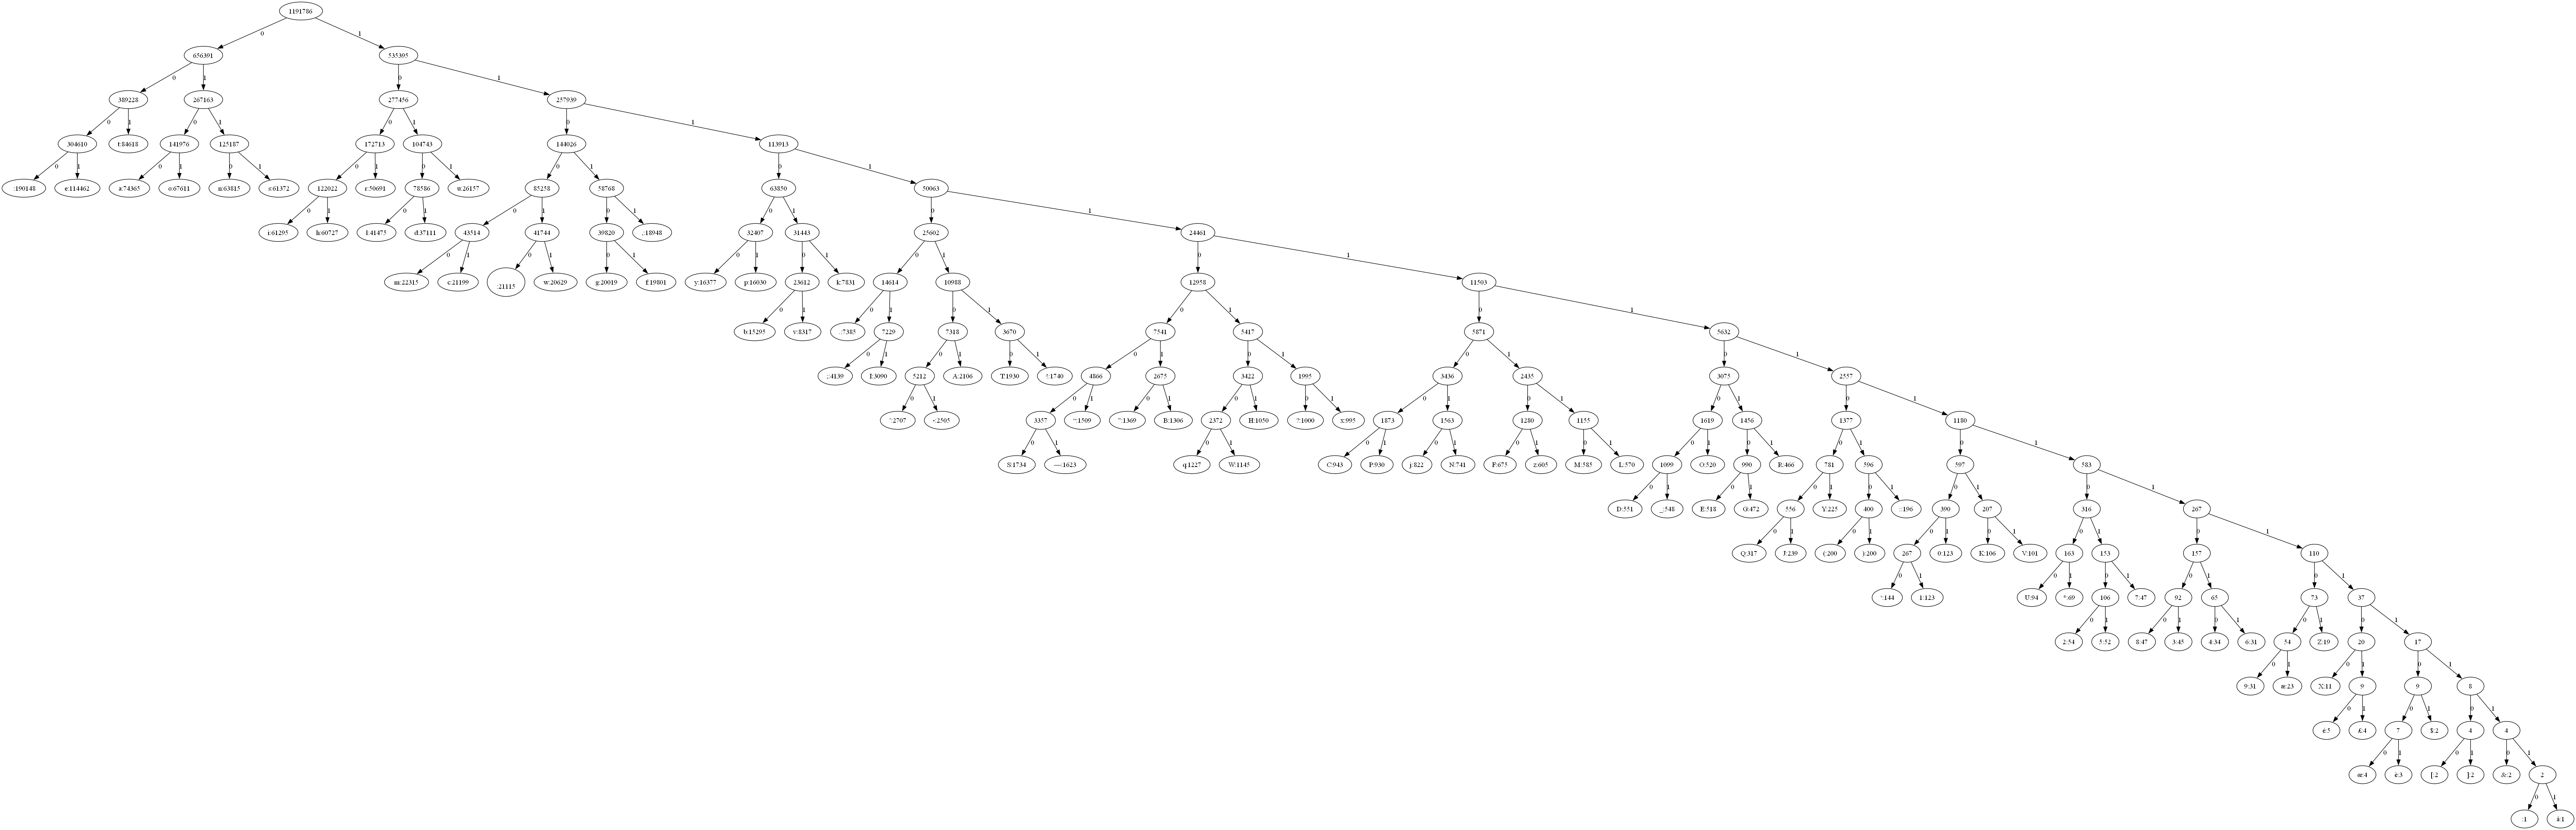

## LZW algorithm
The Lempel-Ziv-Welch algorithm is a dictionary-based encoding scheme, which does not rely on the probability/frequency distribution of the input. Instead it uses a sliding window and a codebook to encode substrings to decimal values.

The LZW algorithm works as follows:
```pseudo
Initialize codebook with individual character strings
w = current observed substring
WHILE not end of input text
	c = current input character
	IF w+c is in codebook
		w = w+c
	ELSE
		output decimal code for w
	add w+c as new entry in codebook
		w=c
	END WHILE
	output decimal code for w

```

In [67]:
def lzw_compress(text: str) -> tuple[list[int], dict[str,int]]:
	"""Compress an input to a list of output symbols.

	Vars:
		text: The input string to compress.
		w: The current string to be compressed.
		c: The current character.
		wc: The concatenation of w and c.

	Returns:
		result: The compressed list of integers.
		dictionary: The codebook mapping substrings to integers.
	"""
	# Build the dictionary with all unique characters in the input text.
	unique_chars = set(text)
	dict_size = len(unique_chars)
	print(f"Original codebook size: {dict_size}")
	dictionary = {char: idx for idx, char in enumerate(unique_chars)}

	# Look for longest known substring w encode it, 
	# concatenate it with the next character c (wc) and add it to the dictionary.
	w = ""
	result: list[int] = []
	for c in text:
		wc = w + c
		if wc in dictionary:
			w = wc
		else:
			if w: # Make sure w is not empty
				result.append(dictionary[w])
			# Add wc to the dictionary.
			dictionary[wc] = dict_size
			dict_size += 1
			w = c

	# Encode the current string w, using its code from the codebook.
	if w:
		result.append(dictionary[w])

	print(f'Final codebook size: {dict_size}')
	return result, dictionary

# Read the content of the file
with open("moby_dick.txt", "r", encoding="utf8") as file:
    text = file.read()

# Compress the text
compressed, codebook = lzw_compress(text)

# Find the largest used codebook index
max_index = max(compressed)

#Calculate number of bits required to represent this index
num_bits = math.ceil(math.log2(max_index + 1))

#Size comparison
original_size = len(text)

compressed_size_LZW = len(compressed) * num_bits / 8
print(f"-"*30)
print(f"Original size: {original_size} bytes")
print(f"Compressed size: {compressed_size_LZW} bytes")
print(f"Compression: {(1-(compressed_size_LZW / original_size)) * 100:.2f}%\n")


# Display an excerpt from the codebook
print(f'Codebook excerpt')
codebook_excerpt = sorted(random.sample(list(codebook.items()), 10), key=lambda item: item[1])

print(f"{'Symbol'.ljust(20)} | {'Decimal'.rjust(7)}")
print("-"*30)
for key, value in codebook_excerpt:
		print(f"{key.ljust(20)} | {str(value).rjust(7)}")

Original codebook size: 91
Final codebook size: 229479
------------------------------
Original size: 1191786 bytes
Compressed size: 516125.25 bytes
Compression: 56.69%

Codebook excerpt
Symbol               | Decimal
------------------------------
! Mi                 |   38020
at whal              |   53449
other na             |   74321
ng wak               |   92432
ishes                |  113043
lask, I              |  141230
 lashe               |  143934
ews al               |  153437
 his head            |  208693
4. The C             |  221880


The LZW algorithm achieves a $56.69\%$ compression, beating both the Huffman and Shannon-Fano algorithm when using character-based encoding. LZW is very effective at encoding repetitive data, if a long substring is repeated multiple times LZW is very efficient, since it only requires a single codebook entry no matter the substring length. The weakness of LZW is the potentially wasteful growth of its dictionary. Each time a substring (w) is encoded, a new entry (w+c) is added to the codebook regardless if this entry is useful for the subsequent encoding of the input.

## Comparison of Huffman, Shannon-Fano and LZW compression

| Feature                | Huffman                     | Shannon-Fano               | LZW                           |
|------------------------|-----------------------------|-----------------------------|-------------------------------|
| **Compression Type**   | Lossless                    | Lossless                    | Lossless                      |
| **Coding Method**      | Variable-length prefix code | Variable-length prefix code | Dictionary-based encoding     |
| **Optimality**         | Optimal based on symbol frequency | Approximate, not always optimal | Not optimal but works well with repetitions |
| **Symbol Dependency**  | Frequency-based             | Frequency-based             | Pattern-based                 |
| **Data Structure**     | Binary tree                 | Recursive splitting (not a binary tree) | Dictionary (dynamic)          |
| **Efficiency**         | High for large datasets with varying frequencies | Good for balanced frequency distributions | High for repetitive data, less effective for unique data |
| **Common Use Cases**   | JPEG, ZIP, audio encoding   | Educational, simple formats (Huffman is more common) | GIF, Unix compress, TIFF      |
| **Strength**           | Guarantees optimal prefix code for given frequencies | Simpler than Huffman, faster to set up | Very effective with repetitive sequences |
| **Weakness**           | Overhead for small or uniform data (has to store frequency table) | Less optimal than Huffman | May grow inefficient for high-entropy data |


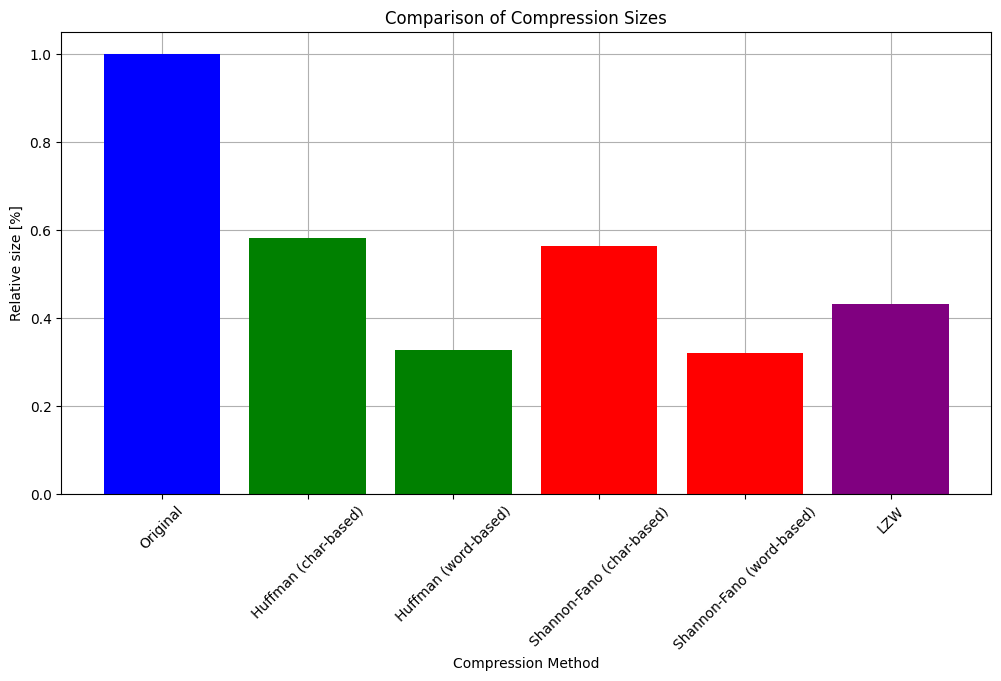

In [68]:
sizes = [original_size,
		compressed_size_char_shannon,
		compressed_size_word_shannon,
		compressed_size_char_huffman,
		compressed_size_word_huffman,
		compressed_size_LZW]
sizes = [size/original_size for size in sizes]

labels = [
    "Original",
    "Huffman (char-based)",
    "Huffman (word-based)",
    "Shannon-Fano (char-based)",
    "Shannon-Fano (word-based)",
    "LZW"]

plt.figure(figsize=(12, 6))
plt.grid(True,zorder=1)
plt.bar(labels, sizes, color=['blue', 'green', 'green', 'red', 'red', 'purple'],zorder=2)
plt.xlabel('Compression Method')
plt.ylabel('Relative size [%]')
plt.title('Comparison of Compression Sizes')
plt.xticks(rotation=45)
plt.show()
